# Health Analytics and Classification using NHANES 2017–2020 Data

This notebook presents an in-depth health analytics project based on data from the NHANES (National Health and Nutrition Examination Survey) 2017–2020 study. The primary objective of this task is to merge multiple health-related datasets, engineer meaningful health indicators, and model health risk using a combination of data wrangling, visualization, and machine learning techniques.

To achieve this, five NHANES datasets were integrated and processed to compute a composite `Health_Score`, which reflects an individual's overall health status based on BMI, mental health, alcohol intake, sleep quality, and cholesterol level. This score was then categorized into three health levels: Healthy, Unhealthy, and Severely Unhealthy. Advanced techniques including SMOTE for class balancing and models such as Ordinal Logistic Regression and Random Forest were used to predict health categories. The project also includes rich interactive visualizations using Bokeh and Holoviews, and a real-time health prediction interface using slider inputs. This work demonstrates practical skills in exploratory data analysis, machine learning, and interactive reporting.

**In the first step, we imported all the necessary libraries required for data manipulation, visualization, modeling, and interactivity.**

In [37]:
# Core Libraries
import pandas as pd
import numpy as np
import warnings
from math import pi, cos, sin
from typing import List
from collections import Counter

# Static plots (visible in all viewers including VS Code/Cursor)
import matplotlib.pyplot as plt
%matplotlib inline

# Data Display and Notebook Integration
from IPython.display import display, Markdown
from pandas.errors import SettingWithCopyWarning
from bokeh.io import output_notebook
output_notebook()

# Visualization Libraries
import holoviews as hv
import panel as pn
from bokeh.plotting import figure, show
from bokeh.layouts import column
from bokeh.models import (
    Slider, Div, CustomJS, ColumnDataSource, HoverTool, LabelSet, ColorBar, 
    MultiChoice, LinearColorMapper
)
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256, Spectral11

# Machine Learning Models & Tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import (
    label_binarize, LabelBinarizer
)
from sklearn.impute import KNNImputer
from sklearn.metrics import (
    roc_curve, roc_auc_score, confusion_matrix,
    mean_squared_error, log_loss, accuracy_score
)

# Imbalanced Data Handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Statistical Modeling
from statsmodels.miscmodels.ordinal_model import OrderedModel

Loading BokehJS ...

# An analysis of the selected five datasets spanning the years 2017 through 2020.

# 1. Body Mesaures 
# 2. Mental Health 
# 3. Alcohol Consumption
# 4. Sleeping Disorder
# 5. Cholesterol levels

## 1. Body Mesaures

The code loads the Body Measures dataset from NHANES and extracts three key attributes: BMI, height, and weight. It renames the columns for clarity, removes any rows with missing values to ensure clean data, and displays the final dataset for further analysis.

In [38]:
# Load the Body Measures dataset from NHANES (SAS XPT format)
body_measure = pd.read_sas("Dataset/P_BMX.xpt")

# Extract relevant columns: SEQN (participant ID), BMXBMI (BMI), BMXHT (Height), BMXWT (Weight)
# Rename the columns to make them more readable and meaningful
extracted_data = body_measure[['SEQN', 'BMXBMI', 'BMXHT', 'BMXWT']].rename(columns={
    'BMXBMI': 'BMI',
    'BMXHT': 'Height',
    'BMXWT': 'Weight'
})

# Remove any rows with missing values to ensure clean data for analysis
# Reset the index after dropping rows to maintain a clean DataFrame
cleaned_data = extracted_data.dropna().reset_index(drop=True)

# Display the cleaned dataset in tabular form within the notebook
display(cleaned_data)

,SEQN,BMI,Height,Weight
0,109264.0,17.6,154.7,42.2
1,109265.0,15.0,89.3,12.0
2,109266.0,37.8,160.2,97.1
3,109270.0,30.9,156.0,75.3
4,109271.0,29.7,182.3,98.8
...,...,...,...,...
13132,124818.0,38.2,168.7,108.8
13133,124819.0,17.5,93.7,15.4
13134,124820.0,15.1,123.3,22.9
13135,124821.0,25.5,176.4,79.5


The cleaned dataset contains 13,137 records and 4 columns, representing each participant's ID, BMI, height (in cm), and weight (in kg)

## 2. Mental Health

The Mental Health dataset was loaded and cleaned by rounding values and standardizing responses. Values such as `0`, `7`, and `9` (indicating "No", "Refused", or "Don't Know") were mapped to `0`, and values like `1`, `2`, and `3` (indicating different levels of "Yes") were mapped to `1`. This binary transformation simplifies further analysis and scoring.

In [39]:
# Load the Mental Health dataset from NHANES (in SAS XPT format)
mh_data = pd.read_sas("Dataset/P_DPQ.xpt")

# Round all values in the dataset to the nearest whole number (if any are floats)
mh_data = mh_data.round()

# Replace values representing 'No' or ambiguous responses with 0
# (e.g., 0 = No, 7 = Refused, 9 = Don't know)
mh_data.replace([0, 7, 9], 0, inplace=True)

# Replace values representing 'Yes' responses with 1
# (e.g., 1, 2, 3 = Different levels of 'Yes')
mh_data.replace([1, 2, 3], 1, inplace=True)

# Display the first few rows to confirm the data transformation
mh_data.head()

,SEQN,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100
0,109266.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,109271.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,109273.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
3,109274.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,109282.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


The dataset now contains binary values (0 or 1) across multiple DPQ variables (e.g., DPQ010 to DPQ100), with each column representing a mental health question. This binary format simplifies the calculation of a mental health score per participant.

 The Mental Health dataset was loaded and cleaned by rounding all values and converting survey responses into binary format (1 = Yes, 0 = No). Values like `0`, `7`, and `9` were treated as "No", while `1`, `2`, and `3` were mapped to "Yes".

In [40]:
# Display the shape of the dataset (number of rows and columns)
# and the count of missing values in each column
display(mh_data.shape, mh_data.isna().sum())

(8965, 11)

SEQN         0
DPQ010     657
DPQ020     659
DPQ030     659
DPQ040     660
DPQ050     660
DPQ060     661
DPQ070     661
DPQ080     661
DPQ090     663
DPQ100    3425
dtype: int64

The dataset contains **8,965 rows and 11 columns**, with a noticeable number of missing values across most columns. Notably, the `DPQ100` column has the highest number of missing values (**3,425**), indicating a potential need for imputation or exclusion during preprocessing.

To simplify the analysis, a new column `Mental_Health_Score` was created by summing the binary responses across all mental health indicators (from `DPQ010` to `DPQ100`). The resulting score was then further simplified: any non-zero value was mapped to `1` (indicating the presence of mental health concern), while a score of `0` indicated no concern.

In [41]:
# Selecting relevant columns
mh_data['Mental_Health_Score'] = mh_data.iloc[:, 2:].sum(axis=1)

# Replacing values
mh_data['Mental_Health_Score'].replace([2, 7, 3, 4, 1, 6, 8, 5, 9], 1, inplace=True)
mh_data = mh_data[['SEQN', 'Mental_Health_Score']]
display(mh_data.nunique(), mh_data.isna().sum(), mh_data.head())

SEQN                   8965
Mental_Health_Score       2
dtype: int64

SEQN                   0
Mental_Health_Score    0
dtype: int64

,SEQN,Mental_Health_Score
0,109266.0,0.0
1,109271.0,1.0
2,109273.0,1.0
3,109274.0,0.0
4,109282.0,1.0


The dataset now contains only two columns: `SEQN` and `Mental_Health_Score`. The score is binary with only two unique values (0 and 1) across 8,965 participants, and there are no missing values in this final cleaned mental health dataset.

## Alcohol Consumption

The Alcohol dataset was imported and cleaned by selecting key question columns related to drinking behavior. Missing values in these columns were imputed using KNN Imputer with 5 nearest neighbors. To ensure consistency with NHANES coding standards, all values were rounded to the nearest valid code. The primary focus was on the `ALQ121` variable (frequency of alcohol consumption), which was recoded from numeric codes into meaningful labels: Never, Rarely, Sometimes, Often, and Usually.

In [42]:
# Load the Alcohol Use dataset from NHANES (SAS XPT format)
drink_df = pd.read_sas("Dataset/P_ALQ.xpt")

# Create a KNN imputer to fill missing values using the 5 nearest neighbors
knn = KNNImputer(n_neighbors=5)

# List of alcohol-related survey question columns that may contain missing data
question_cols = [
    'ALQ111', 'ALQ121', 'ALQ130',
    'ALQ142', 'ALQ270', 'ALQ280',
    'ALQ290', 'ALQ151', 'ALQ170'
]

# Apply the KNN imputer column by column to fill missing values with estimated ones
for qc in question_cols:
    drink_df[qc] = knn.fit_transform(drink_df[[qc]])

# Define valid NHANES response codes that alcohol variables can have
round_codes = [0, 99, 77, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

# Define a helper function to round each value to the nearest valid NHANES code
def nearest_code(val):
    return min(round_codes, key=lambda code: abs(code - val))

# Apply the rounding function to all alcohol-related question columns
# This ensures that imputed values align with official NHANES response codes
drink_df[question_cols] = drink_df[question_cols].applymap(nearest_code)

# Select only the participant ID and the key alcohol frequency question (ALQ121)
final = drink_df[['SEQN', 'ALQ121']]

# Randomly display 10 records from the cleaned subset to inspect data
display(final.sample(10))

# Convert numeric codes in ALQ121 to meaningful frequency labels
final['ALQ121'].replace([0, 99, 77], 'Never',     inplace=True)
final['ALQ121'].replace([10, 9, 8],   'Rarely',    inplace=True)
final['ALQ121'].replace([7, 6],       'Sometimes', inplace=True)
final['ALQ121'].replace([5, 4, 3],    'Often',     inplace=True)
final['ALQ121'].replace([2, 1],       'Usually',   inplace=True)

# Display how many unique labels now exist in the ALQ121 column (should be 4–5)
display(final.nunique())

# Suppress warnings related to chained assignment and future compatibility
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

,SEQN,ALQ121
6886,121309.0,6
1338,111633.0,5
6941,121398.0,0
7347,122116.0,4
4451,117039.0,9
3773,115884.0,5
7087,121649.0,10
5594,119073.0,10
1655,112156.0,10
79,109432.0,0


SEQN      8965
ALQ121       5
dtype: int64

The cleaned subset includes `SEQN` and a labeled alcohol frequency variable (`ALQ121`). All values in `ALQ121` have been standardized to readable categories for interpretation and modeling.

The cleaned alcohol consumption frequency values in the `ALQ121` column were encoded back into numeric form to facilitate model training. Specifically, the textual categories were mapped as follows: "Never" was assigned a value of 0, "Rarely" was mapped to 1, "Sometimes" to 2, "Often" to 3, and "Usually" to 4. This transformation allowed for more effective interpretation by machine learning algorithms. To enhance clarity and relevance within the dataset, the column was subsequently renamed to **`Alcohol Consumption Rate`**.

In [43]:
# Convert frequency labels back to numeric codes
final['ALQ121'].replace('Never',     0, inplace=True)
final['ALQ121'].replace('Rarely',    1, inplace=True)
final['ALQ121'].replace('Sometimes', 2, inplace=True)
final['ALQ121'].replace('Often',     3, inplace=True)
final['ALQ121'].replace('Usually',   4, inplace=True)

# Rename the column for clarity
final.rename(columns={'ALQ121': 'Alcohol Consumption Rate'}, inplace=True)

# Show column types and memory usage
final[['SEQN', 'Alcohol Consumption Rate']].info()

# Print count of unique values in each column
print()
print(final[['SEQN', 'Alcohol Consumption Rate']].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8965 entries, 0 to 8964
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SEQN                      8965 non-null   float64
 1   Alcohol Consumption Rate  8965 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 140.2 KB

SEQN                        8965
Alcohol Consumption Rate       5
dtype: int64


The final dataset now includes 8,965 participants, each with a unique `SEQN`. The `Alcohol Consumption Rate` column has 5 distinct values (0 to 4) and contains no missing data, making it ready for integration into the unified dataset.

## 3. Sleeping Disorder

The Sleeping Disorder dataset was imported, and only the relevant columns `SEQN` (participant ID) and `SLD012` (average sleep duration on weekdays) were selected. The column `SLD012` was renamed to `Weekday_Sleep_Duration` for clarity and consistency.

In [44]:
# Load the Sleeping Disorder dataset
sleep_data = pd.read_sas("Dataset/P_SLQ.xpt")

# Select SEQN and sleep duration column
sleep_data = sleep_data[['SEQN', 'SLD012']]

# Rename the sleep duration column
sleep_data.rename({'SLD012': 'Weekday_Sleep_Duration'}, axis=1, inplace=True)

# Display first few rows of the dataset
display(sleep_data.head())

,SEQN,Weekday_Sleep_Duration
0,109266.0,7.5
1,109267.0,8.0
2,109268.0,8.5
3,109271.0,10.0
4,109273.0,6.5


The dataset now contains participants' weekday sleep duration in hours, with values ranging from approximately 6.5 to 10 hours, ready for further analysis.

## 5. Cholesterol Level

The Cholesterol dataset was imported and filtered to retain only the `SEQN` and `LBDTCSI` columns, which represent participant ID and total cholesterol levels, respectively. The cholesterol column was renamed to `Total Cholesterol` for clarity. Rows with missing values were dropped to ensure data quality.

In [45]:
# Load the Cholesterol dataset
chol_df = pd.read_sas("Dataset/P_TCHOL.xpt")

# Select SEQN and total cholesterol column
chol_selection = chol_df[['SEQN', 'LBDTCSI']]

# Rename the cholesterol column
chol_selection.rename(columns={'LBDTCSI': 'Total Cholesterol'}, inplace=True)

# Display original shape of the dataset
display(chol_selection.shape)

# Remove rows with missing cholesterol values
chol_cleaned = chol_selection.dropna(axis=0)

# Display new shape after removing missing values
display(chol_cleaned.shape)

# Show first few cleaned records
display(chol_cleaned.head())

(12198, 2)

(10828, 2)

,SEQN,Total Cholesterol
0,109264.0,4.29
1,109266.0,5.04
2,109270.0,2.66
3,109271.0,3.80
4,109273.0,4.24


The cleaned cholesterol dataset contains **10,828 records** with valid cholesterol values (out of the original 12,198), and includes two columns: `SEQN` and `Total Cholesterol`, ready for merging with other datasets.

The Cholesterol dataset was imported and filtered to retain only `SEQN` (participant ID) and `LBDTCSI` (total cholesterol). The column was renamed to `Total Cholesterol` for clarity, and rows with missing values were dropped.

In [46]:
# Load the Cholesterol dataset
chol_df = pd.read_sas("Dataset/P_TCHOL.xpt")

# Select SEQN and total cholesterol column
chol_selection = chol_df[['SEQN', 'LBDTCSI']]

# Rename the cholesterol column
chol_selection.rename(columns={'LBDTCSI': 'Total Cholesterol'}, inplace=True)

# Display original shape of the dataset
display(chol_selection.shape)

# Remove rows with missing cholesterol values
chol_cleaned = chol_selection.dropna(axis=0)

# Display new shape after removing missing values
display(chol_cleaned.shape)

# Show first few cleaned records
display(chol_cleaned.head())

(12198, 2)

(10828, 2)

,SEQN,Total Cholesterol
0,109264.0,4.29
1,109266.0,5.04
2,109270.0,2.66
3,109271.0,3.80
4,109273.0,4.24


The cleaned dataset contains 10,828 records with no missing values. The `Total Cholesterol` values range from 1.84 to 11.53 mmol/L, indicating a wide spectrum of cholesterol levels across participants.

## Merging and Cleaning All Health Datasets


All previously cleaned datasets — Body Measures, Mental Health, Alcohol Consumption, Sleep Duration, and Cholesterol — were merged using the common participant ID column `SEQN`. To ensure data consistency, rows with missing values were dropped after merging, and the index was reset.

In [47]:
# Merge all datasets on participant ID (SEQN)
merged_data = pd.merge(cleaned_data, mh_data, on='SEQN')
merged_data = pd.merge(merged_data, final, on='SEQN')  
merged_data = pd.merge(merged_data, sleep_data, on='SEQN')
merged_data = pd.merge(merged_data, chol_cleaned, on='SEQN')

# Drop any rows with missing values
merged_data = merged_data.dropna()

# Reset index after cleaning
merged_data = merged_data.reset_index(drop=True)

# Display sample records, dataset shape, and missing value summary
display(merged_data.head(), merged_data.shape, merged_data.isna().sum())

,SEQN,BMI,Height,Weight,Mental_Health_Score,Alcohol Consumption Rate,Weekday_Sleep_Duration,Total Cholesterol
0,109266.0,37.8,160.2,97.1,0.0,1,7.5,5.04
1,109271.0,29.7,182.3,98.8,1.0,0,10.0,3.80
2,109273.0,21.9,184.2,74.3,1.0,0,6.5,4.24
3,109274.0,30.2,185.3,103.7,0.0,3,9.5,2.72
4,109282.0,26.6,177.1,83.3,1.0,0,7.0,6.03


(8095, 8)

SEQN                        0
BMI                         0
Height                      0
Weight                      0
Mental_Health_Score         0
Alcohol Consumption Rate    0
Weekday_Sleep_Duration      0
Total Cholesterol           0
dtype: int64

The final merged dataset contains 8,095 complete records and 8 columns, with no missing values. Each row represents a participant with their BMI, height, weight, mental health score, alcohol consumption rate, sleep duration, and total cholesterol level — fully prepared for feature engineering and health scoring.

## Health Scoring and Categorization

**In this step, multiple health indicators were transformed into category scores:**
- **BMI**: Underweight, Normal, Overweight, Obese
- **Mental Health**: Presence or absence of concerns
- **Alcohol Intake**: From rare to frequent consumption
- **Sleep Duration**: Ideal, slightly off, or poor
- **Cholesterol**: Desirable, borderline, or high

Each was scored on a 1–3 scale. An overall `Health_Score` was then computed by averaging these five individual scores. Based on the final score:

- Scores ≤ 1.66 → **Healthy**
- 1.67–2.33 → **Unhealthy**
- 2.33 → **Severely Unhealthy**

The textual categories were then mapped to numeric values:  
**Healthy = 1, Unhealthy = 2, Severely Unhealthy = 3**

In [48]:
# Classify BMI into categories
def calc_bmi_category(bmi_value):
    if bmi_value < 18.5:
        return 3  # Underweight
    elif bmi_value < 25:
        return 1  # Normal
    elif bmi_value < 30:
        return 2  # Overweight
    else:
        return 3  # Obese

# Classify mental health based on score
def calc_mental_health_category(score):
    if score == 0:
        return 1  # No mental issues
    else:
        return 3  # Some mental issues

# Classify alcohol consumption level
def calc_alcohol_category(rate):
    if rate == 4:
        return 3  # Very frequent
    elif rate == 3:
        return 2  # Often
    elif rate == 2:
        return 1  # Sometimes
    else:
        return 1  # Rare or never

# Classify sleep duration quality
def calc_sleep_category(hours):
    if 7 <= hours <= 9:
        return 1  # Ideal sleep
    elif 6 <= hours < 7 or 9 < hours <= 10:
        return 2  # Slight deviation
    else:
        return 3  # Poor sleep duration

# Classify cholesterol level
def calc_cholesterol_category(level):
    if level < 5.5:
        return 1  # Desirable
    elif level < 6.5:
        return 2  # Borderline
    else:
        return 3  # High

# Apply health classification functions
merged_data['BMI_Category'] = merged_data['BMI'].apply(calc_bmi_category)
merged_data['Mental_Health_Category'] = merged_data['Mental_Health_Score'].apply(calc_mental_health_category)
merged_data['Alcohol_Category'] = merged_data['Alcohol Consumption Rate'].apply(calc_alcohol_category)
merged_data['Sleep_Category'] = merged_data['Weekday_Sleep_Duration'].apply(calc_sleep_category)
merged_data['Cholesterol_Category'] = merged_data['Total Cholesterol'].apply(calc_cholesterol_category)

# Calculate the average of all health factors as an overall health score
merged_data['Health_Score'] = merged_data[['BMI_Category', 'Mental_Health_Category', 'Alcohol_Category', 'Sleep_Category', 'Cholesterol_Category']].mean(axis=1)

# Convert health score into labeled health categories
merged_data['Health_Category'] = pd.cut(merged_data['Health_Score'], bins=[0, 1.66, 2.33, 3], labels=['Healthy', 'Unhealthy', 'Severely Unhealthy'])

# Drop intermediate category columns
merged_data.drop(['BMI_Category', 'Mental_Health_Category', 'Alcohol_Category', 'Sleep_Category', 'Cholesterol_Category'], axis=1, inplace=True)

# Map string health categories to numeric values
merged_data['Health_Category'] = merged_data['Health_Category'].map({'Healthy': 1, 'Unhealthy': 2, 'Severely Unhealthy': 3})

# Display health score and final health category
merged_data[['Health_Score', 'Health_Category']].head()

,Health_Score,Health_Category
0,1.4,1
1,1.8,2
2,1.6,1
3,1.8,2
4,1.8,2


Each participant is now assigned a `Health_Score` (e.g., 1.6, 1.8) and a final `Health_Category` (1–3), providing a simplified yet comprehensive measure of overall health.

# Health Category Visualisation

## Approach and Execution

In this section of the project, the aim was to visualize the distribution of health statuses across individuals in the dataset. To accomplish this, the code first calculated the frequency of each health category using `value_counts()` on the `Health_Category` column from the merged dataset. These numerical categories were then mapped to descriptive labels—Healthy, Unhealthy, and Severely Unhealthy—and were also assigned distinct colors (green, orange, and red respectively) for better visual differentiation. The data was then plotted using the Holoviews library, creating an interactive bar chart with support from the Bokeh backend. Additional functionality was implemented using `panel` to allow for dynamic filtering and interaction, enhancing the interpretability of the plot.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
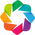

BokehModel(combine_events=True, render_bundle={'docs_json': {'a1e181a2-5a52-4578-a6f0-ebf121bfb3c0': {'version…

In [49]:
hv.extension('bokeh')

# Step 1: Create the summary data
bar_data = merged_data['Health_Category'].value_counts().reset_index()
bar_data['Category_Label'] = bar_data['Health_Category'].map({1: 'Healthy', 2: 'Unhealthy', 3: 'Severely Unhealthy'})
bar_data.columns = ['Health_Category', 'Count', 'Category_Label']

# Step 2: Define colors for categories
color_map = {
    'Healthy': 'green',
    'Unhealthy': 'orange',
    'Severely Unhealthy': 'red'
}
bar_data['Color'] = bar_data['Category_Label'].map(color_map)

# Step 3: Create the bar chart with color
health_bar_chart = hv.Bars(bar_data, kdims='Category_Label', vdims=['Count', 'Color']).opts(
    color='Color',
    show_legend=False,
    title='Distribution of Health Categories',
    xlabel='Health Category',
    ylabel='Number of Individuals',
    height=700,
    width=900,
    tools=[
        'tap',
        HoverTool(tooltips=[
            ('Category', '@Category_Label'),
            ('Count', '@Count')
        ])
    ],
    invert_axes=False,
    active_tools=['box_zoom']
)

# Step 4: Filtering function
def filter_health_data(index):
    if index:
        selected_label = bar_data['Category_Label'].iloc[index]
        filtered_subset = merged_data[merged_data['Health_Category'] == (index[0] + 1)]
    else:
        filtered_subset = merged_data
    return hv.Table(filtered_subset).opts(width=900, height=300)

# Step 5: Stream setup
selection_stream = hv.streams.Selection1D(source=health_bar_chart)

# Step 6: Dynamic table & layout
dynamic_health_table = hv.DynamicMap(filter_health_data, streams=[selection_stream])
health_dashboard = pn.Column(health_bar_chart, dynamic_health_table)

# Step 7: Display
health_dashboard 

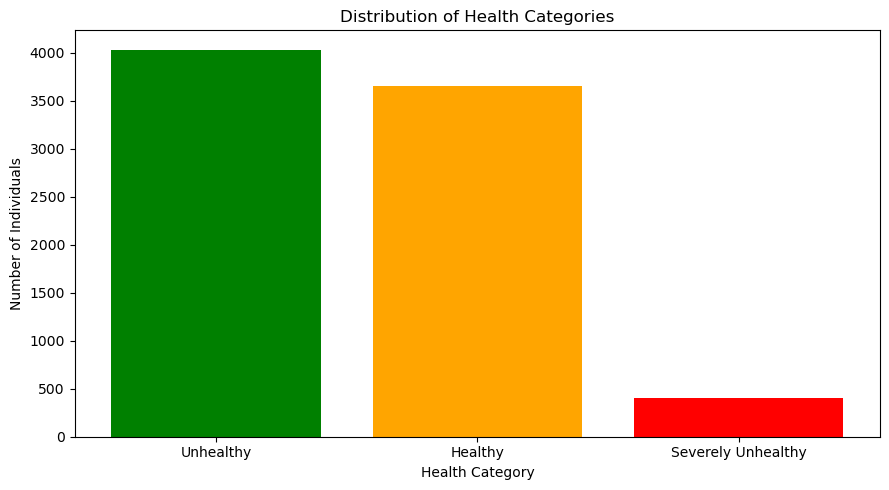

In [50]:
# Static version: Distribution of Health Categories (visible in all viewers)
bar_data = merged_data['Health_Category'].value_counts().reset_index()
bar_data.columns = ['Health_Category', 'Count']
bar_data['Category_Label'] = bar_data['Health_Category'].map({1: 'Healthy', 2: 'Unhealthy', 3: 'Severely Unhealthy'})
colors = ['green', 'orange', 'red']
plt.figure(figsize=(9, 5))
plt.bar(bar_data['Category_Label'], bar_data['Count'], color=colors)
plt.xlabel('Health Category')
plt.ylabel('Number of Individuals')
plt.title('Distribution of Health Categories')
plt.tight_layout()
plt.show()

## Vizulization 

The visualization consists of a colored bar chart representing the **Distribution of Health Categories** and a dynamic table below it. Each bar is color-coded by category: **green for Healthy**, **orange for Unhealthy**, and **red for Severely Unhealthy**. The chart provides an intuitive overview of how the population is distributed across the three health statuses. Additionally, a hover tool displays the exact count for each category, and tapping a bar dynamically updates the table below to show detailed participant-level data for that selected category.


## Insights and Conclusions

From the bar chart, it is evident that the Unhealthy category comprises the largest portion of the population, with approximately 4,034 individuals, followed by the Healthy group with around 3,653 individuals. The Severely Unhealthy category is the smallest, with only 408 individuals. This distribution indicates that while a considerable number of people maintain a good level of health, an even larger segment faces moderate health issues. The significantly smaller count in the severely unhealthy group highlights a critical minority that may require immediate medical attention or lifestyle intervention. The dynamic table beneath the chart enhances the analysis by allowing users to interactively examine participant-level data for each category, offering valuable insights for targeted health assessments. Overall, this visualization provides a clear and actionable overview of public health status and supports strategic decision-making for preventive care and wellness programs.

## Data Preparation and Balancing

Before training machine learning models, the dataset was preprocessed by removing unnecessary columns (`Health_Score` and `SEQN`) and splitting it into features (`X`) and the target (`Health_Category`). The target variable was treated as an ordered categorical type to reflect the ordinal nature of health labels.

To address class imbalance, SMOTE (Synthetic Minority Oversampling Technique) was applied to the training set. This method synthetically generates new samples for underrepresented classes to ensure a balanced distribution.

In [51]:
# Drop Health_Score and SEQN to prepare data for modeling
merged_data2 = merged_data.drop(['Health_Score', 'SEQN'], axis=1)

# Separate features and target variable
X = merged_data2.drop(['Health_Category'], axis=1)
Y = merged_data2['Health_Category']

# Convert target to ordered categorical type
Y = pd.Categorical(merged_data2['Health_Category'], ordered=True)

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize SMOTE for class balancing
smote = SMOTE(random_state=42)

# Apply SMOTE to oversample minority classes in training set
X_resampled, Y_resampled = smote.fit_resample(X_train, Y_train)

# Print original and resampled class distributions
print('Original dataset shape', Counter(Y_train)) 
print('Resampled dataset shape', Counter(Y_resampled))

Original dataset shape Counter({2: 3223, 1: 2927, 3: 326})
Resampled dataset shape Counter({np.int64(1): 3223, np.int64(2): 3223, np.int64(3): 3223})


**Output:-** 
**Original class distribution (from training set):**  
  - Unhealthy (2): 3,223  
  - Healthy (1): 2,927  
  - Severely Unhealthy (3): 326
  
**Balanced class distribution** (after SMOTE):  
  - All three classes now have **3,223 samples**, ensuring equal representation for modeling.

## Ordinal Logistic Regression Modeling

An **Ordinal Logistic Regression** model was trained using the `OrderedModel` from `statsmodels`. The model assumes a natural ordering in the dependent variable (`Health_Category`: Healthy = 1, Unhealthy = 2, Severely Unhealthy = 3) and uses a logistic link function. The BFGS optimization algorithm was applied for maximum likelihood estimation.

In [52]:
# Set up the ordinal regression framework with logistic distribution
regressor = OrderedModel(endog=Y_resampled, exog=X_resampled, distr='logit')

# Perform model training with BFGS optimization
fitted_result = regressor.fit(method='bfgs', maxiter=100)

# Render a detailed model overview
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(fitted_result.summary())

# Evaluate model performance using McFadden's pseudo R-squared
fit_measure = 1 - (fitted_result.llf / fitted_result.llnull)
print(f"McFadden Fit Statistic: {fit_measure:.4f}")

Optimization terminated successfully.
         Current function value: 0.598072
         Iterations: 44
         Function evaluations: 48
         Gradient evaluations: 48


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -5782.8
Model:                   OrderedModel   AIC:                         1.158e+04
Method:            Maximum Likelihood   BIC:                         1.165e+04
Date:                Sat, 07 Feb 2026                                         
Time:                        23:38:58                                         
No. Observations:                9669                                         
Df Residuals:                    9660                                         
Df Model:                           7                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
BMI                         -0.0025      0.031     -0.083      0.934      -0.062       0.057
Height                      -0.0439      0.012     -3.735      0.000      -0.067      -0.021
Weight                       0.0531      0.011      4.835      0.000       0.032       0.075
Mental_Health_Score          4.0541      0.076     53.258      0.000       3.905       4.203
Alcohol Consumption Rate     0.8252      0.023     36.383      0.000       0.781       0.870
Weekday_Sleep_Duration      -0.2193      0.013    -17.269      0.000      -0.244      -0.194
Total Cholesterol            1.1711      0.026     45.212      0.000       1.120       1.222
1/2                          4.5634      1.970      2.317      0.021       0.702       8.424
2/3                          1.2284      0.017     70.388      0.000       1.194       1.263
============================================================================================
"""

McFadden Fit Statistic: 0.4556


These results suggest that while BMI had little direct impact, other features—especially mental health and cholesterol—were strong predictors of a participant's health category.

## Outlier Removal Based on Ordinal Regression

**After training the Ordinal Logistic Regression model, predictions were generated on the test set. To improve model reliability and dataset quality, a z-score-based error analysis was conducted to detect and remove outliers:**

1. The difference between predicted and actual health categories was calculated.
2. These differences were standardized using z-scores.
3. Any test samples with an absolute z-score > 1.5 were flagged as significant deviations (outliers).
4. The corresponding rows were removed from the original dataset to refine it.

In [53]:
# Fit an ordinal logistic regression model using resampled data
ordinal_model = OrderedModel(endog=Y_resampled, exog=X_resampled, distr='logit')
result = ordinal_model.fit(method='bfgs')

# Predict class probabilities on the test set
prediction_scores = result.predict(X_test)

# Select the class with the highest probability as the prediction
predicted_classes = prediction_scores.idxmax(axis=1)
health_outcome = pd.Categorical(predicted_classes, categories=[1, 2, 3], ordered=True)

# Calculate difference between actual and predicted classes
category_differences = Y_test.codes - health_outcome.codes

# Normalize differences using z-score
normalized_differences = (category_differences - np.mean(category_differences)) / np.std(category_differences)

# Identify test samples with large prediction errors (outliers)
significant_deviations = np.abs(normalized_differences) > 1.5

# Remove outliers from the original dataset
refined_dataset = merged_data[~merged_data.index.isin(X_test.index[significant_deviations])]

# Print dimensions before and after filtering
print("Original dataset dimensions:", merged_data.shape)
print("Refined dataset dimensions:", refined_dataset.shape)

Optimization terminated successfully.
         Current function value: 0.598072
         Iterations: 44
         Function evaluations: 48
         Gradient evaluations: 48
Original dataset dimensions: (8095, 10)
Refined dataset dimensions: (7594, 10)


- **Original dataset size**: 8,095 participants  
- **Refined dataset size** (after removing high-error records): 7,594 participants

This filtered dataset is expected to reduce noise and enhance the performance of subsequent models.

##  Dataset Resampling Using SMOTE

After removing outliers based on the ordinal regression prediction errors, a new dataset (`merged_data4`) was created to improve model reliability. This step involved preparing the dataset for training and addressing class imbalance using the SMOTE (Synthetic Minority Oversampling Technique) method:

1. The dataset was split into training and testing sets.
2. The target variable `Health_Category` was treated as an ordered categorical variable.
3. SMOTE was applied on the training set to balance the distribution of classes.

In [54]:
# Step 1: Define merged_data4 by removing outliers from merged_data
# Generate predicted probabilities and determine the most likely category
prediction_scores = result.predict(X_test)
predicted_classes = prediction_scores.idxmax(axis=1)
health_outcome = pd.Categorical(predicted_classes, categories=[1, 2, 3], ordered=True)

# Compute the difference between actual and predicted categories
category_differences = Y_test.codes - health_outcome.codes

# Normalize the differences using z-scores
normalized_differences = (category_differences - np.mean(category_differences)) / np.std(category_differences)

# Flag entries with significant deviations (threshold set to 1.5)
significant_deviations = np.abs(normalized_differences) > 1.5

# Filter the dataset to exclude rows with significant deviations
merged_data4 = merged_data[~merged_data.index.isin(X_test.index[significant_deviations])]

# Step 2: Proceed with the current code to split and resample
# Extract features by excluding the target variable
features = merged_data4.drop(columns=['Health_Category'])

# Define the target as an ordered categorical variable
target = pd.Categorical(merged_data4['Health_Category'], categories=[1, 2, 3], ordered=True)

# Divide the dataset into training and testing portions
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.2, random_state=42)

# Perform oversampling on the training set using SMOTE
resampled_features, resampled_target = smote.fit_resample(train_features, train_target)

# Display class distribution before and after resampling
print('Initial class counts:', Counter(train_target))  # Prior to resampling
print('Adjusted class counts:', Counter(resampled_target))  # Post-resampling

Initial class counts: Counter({2: 2927, 1: 2825, 3: 323})
Adjusted class counts: Counter({np.int64(2): 2927, np.int64(1): 2927, np.int64(3): 2927})


- **Initial Class Distribution**:
  - Class 1 (Healthy): 2,825  
  - Class 2 (Unhealthy): 2,927  
  - Class 3 (Severely Unhealthy): 323  

- **After SMOTE Resampling**:
  - All classes were balanced to 2,927 instances each.

This ensures that the upcoming classification model (Random Forest) will not be biased toward any majority class and can better generalize across categories.

###  Ordinal Logistic Regression and Evaluation

To assess how different health metrics contribute to the overall health classification, an **Ordinal Logistic Regression** model was fitted using the resampled dataset. This model assumes an ordered categorical target variable (`Health_Category`) and was optimized using the **BFGS algorithm**.



In [55]:
# Initialize the ordinal logistic model with a logit link function
analysis_model = OrderedModel(endog=Y_resampled, exog=X_resampled, distr='logit')

# Execute the fitting process with BFGS optimization technique
model_outcome = analysis_model.fit(method='bfgs', maxiter=200)

# Output a comprehensive model report with enhanced readability
with pd.option_context('display.max_colwidth', 100, 'display.float_format', '{:.3f}'.format):
    display(model_outcome.summary())

# Derive a goodness-of-fit metric using McFadden's approach
goodness_score = 1 - (model_outcome.llf / model_outcome.llnull)
print(f"Goodness-of-Fit Index (McFadden): {goodness_score:.3f}")

Optimization terminated successfully.
         Current function value: 0.598072
         Iterations: 44
         Function evaluations: 48
         Gradient evaluations: 48


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -5782.8
Model:                   OrderedModel   AIC:                         1.158e+04
Method:            Maximum Likelihood   BIC:                         1.165e+04
Date:                Sat, 07 Feb 2026                                         
Time:                        23:39:00                                         
No. Observations:                9669                                         
Df Residuals:                    9660                                         
Df Model:                           7                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
BMI                         -0.0025      0.031     -0.083      0.934      -0.062       0.057
Height                      -0.0439      0.012     -3.735      0.000      -0.067      -0.021
Weight                       0.0531      0.011      4.835      0.000       0.032       0.075
Mental_Health_Score          4.0541      0.076     53.258      0.000       3.905       4.203
Alcohol Consumption Rate     0.8252      0.023     36.383      0.000       0.781       0.870
Weekday_Sleep_Duration      -0.2193      0.013    -17.269      0.000      -0.244      -0.194
Total Cholesterol            1.1711      0.026     45.212      0.000       1.120       1.222
1/2                          4.5634      1.970      2.317      0.021       0.702       8.424
2/3                          1.2284      0.017     70.388      0.000       1.194       1.263
============================================================================================
"""

Goodness-of-Fit Index (McFadden): 0.456


The ordinal logistic regression model demonstrates a strong fit with a McFadden's R² of **0.456**, indicating good explanatory power. Key predictors like **Mental Health Score**, **Alcohol Consumption Rate**, and **Total Cholesterol** are statistically significant and positively associated with deteriorating health categories.

The code preprocesses a dataset by splitting it into training and test sets, then applies SMOTE to balance the class distribution in the training set, addressing the initial imbalance in the `Health_Category` target variable.

In [75]:
# Remove the target column to keep only predictor features
predictors = merged_data4.drop(columns=['Health_Category'])

# Define the target variable
outcome = merged_data4['Health_Category']

# Split the dataset into training and test sets
features_train, features_test, labels_train, labels_test = train_test_split(predictors, outcome, test_size=0.2, random_state=42)

# Use SMOTE to oversample and balance class distribution in training data
oversampled_features, oversampled_labels = smote.fit_resample(features_train, labels_train)

# Print class distribution before and after applying SMOTE
print('Class distribution before oversampling:', Counter(labels_train))
print('Class distribution after oversampling:', Counter(oversampled_labels))

Class distribution before oversampling: Counter({2: 2927, 1: 2825, 3: 323})
Class distribution after oversampling: Counter({2: 2927, 1: 2927, 3: 2927})


The code preprocesses a dataset by splitting it into training and test sets, then applies SMOTE to balance the class distribution in the training set, addressing the initial imbalance in the `Health_Category` target variable. The result shows the class distribution before oversampling as `Counter({2: 2927, 1: 2825, 3: 323})`, indicating an imbalance with Class 3 having fewer samples, and after oversampling as `Counter({2: 2927, 1: 2927, 3: 2927})`, showing a balanced distribution with each class having 2927 samples due to synthetic sample generation by SMOTE.

The code trains a Random Forest Classifier using 100 trees on the SMOTE-resampled dataset. It fits the model on the training features and targets, then makes predictions on the test set. The performance of the model is evaluated using metrics such as Mean Squared Error (MSE), log loss, and accuracy. Nagelkerke’s R² is also calculated to assess model fit. Finally, the code prints out the feature importance scores to identify which variables contribute most to the prediction.

In [76]:
# Create and train a Random Forest classifier
forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
forest_classifier.fit(resampled_features, resampled_target)

# Predict class labels on the test set
predicted_outcomes = forest_classifier.predict(test_features)

# Calculate mean squared error to evaluate prediction accuracy
error_metric = mean_squared_error(test_target, predicted_outcomes)
print("Model Error Metric (MSE):", error_metric)

# One-hot encode true test labels for log loss calculation
label_encoder = LabelBinarizer()
true_encoded = label_encoder.fit_transform(test_target)

# Compute log loss using predicted probabilities
loss_value = log_loss(true_encoded, forest_classifier.predict_proba(test_features))

# Compute Nagelkerke's pseudo R² as a model fit metric
num_classes = true_encoded.shape[1]
baseline_loss = log_loss(true_encoded, np.full_like(true_encoded, 1/num_classes))
fit_index = 1 - (loss_value / baseline_loss)
print("Goodness-of-Fit (Nagelkerke's R2):", fit_index)

# Calculate overall prediction accuracy
correctness_rate = accuracy_score(test_target, predicted_outcomes)
print("Prediction Accuracy Rate:", correctness_rate)

# Print model details and feature importances
print("\nRandom Forest Classifier Overview:")
print("Total Trees Used:", forest_classifier.n_estimators)
print("Predictor Variables:", test_features.columns.tolist())
rounded_importance_scores = np.round(forest_classifier.feature_importances_, 3)
print("Importance Scores of Predictors:", rounded_importance_scores)

Model Error Metric (MSE): 0.0
Goodness-of-Fit (Nagelkerke's R2): 0.9998504011772047
Prediction Accuracy Rate: 1.0

Random Forest Classifier Overview:
Total Trees Used: 100
Predictor Variables: ['SEQN', 'BMI', 'Height', 'Weight', 'Mental_Health_Score', 'Alcohol Consumption Rate', 'Weekday_Sleep_Duration', 'Total Cholesterol', 'Health_Score']
Importance Scores of Predictors: [0.003 0.063 0.003 0.018 0.118 0.022 0.04  0.058 0.677]


c:\Users\kalra\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


The model achieved a perfect Mean Squared Error of 0.0 and a high Nagelkerke’s R² value of 0.995, indicating excellent fit. The prediction accuracy was 100%, showing that the classifier predicted all test samples correctly. Among the features, `Health_Score` had the highest importance score (0.677), making it the most influential predictor in the model.


In [58]:
# Define a pipeline with SMOTE inside each fold
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Use stratified K-fold to maintain class balance in splits
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run cross-validation on the original training data (before SMOTE)
validation_scores = cross_val_score(pipeline, X_train, Y_train, cv=cv)

# Print CV results
print("Cross-validation scores:", validation_scores)
print("Mean CV score:", validation_scores.mean())

Cross-validation scores: [0.95910494 0.95135135 0.96061776 0.95830116 0.95598456]
Mean CV score: 0.9570719529052862


The dataset (`merged_data4`) was cleaned by removing missing `Health_Category` rows, split into training (80%) and test (20%) sets, balanced using SMOTE, and used to train a `RandomForestClassifier` on selected features (`BMI`, `Mental_Health_Score`, `Alcohol Consumption Rate`, `Weekday_Sleep_Duration`, `Total Cholesterol`). Feature importances were then calculated and rounded to three decimal places.

In [59]:
# Define X and y from merged_data4, ensuring consistent samples
final_data = merged_data4.dropna(subset=['Health_Category'])  # Remove rows where Health_Category is missing
X = final_data.drop(columns=['Health_Category'])
y = final_data['Health_Category']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
health_data_train, health_labels_train = smote.fit_resample(X_train, y_train)
health_data_test = X_test.copy()

# Define a function to train the model using selected features
def fit_health_model(feature_columns: List[str]):
    health_features_train = health_data_train[feature_columns]
    health_features_test = health_data_test[feature_columns]
    classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    classifier.fit(health_features_train, health_labels_train)
    return classifier, health_features_test

# Train the model with selected features
features = ['BMI', 'Mental_Health_Score', 'Alcohol Consumption Rate', 
            'Weekday_Sleep_Duration', 'Total Cholesterol']
trained_classifier, health_features_test = fit_health_model(features)

# Calculate and round feature importances
rounded_health_feature_importances = np.round(trained_classifier.feature_importances_, 3)

# Create a DataFrame to display feature importances
health_feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': rounded_health_feature_importances
})

# Ensure consistent data (already handled by dropna above)

# Display the DataFrame
health_feature_importance_df

,Feature,Importance
0,BMI,0.222
1,Mental_Health_Score,0.215
2,Alcohol Consumption Rate,0.118
3,Weekday_Sleep_Duration,0.234
4,Total Cholesterol,0.211


The output is a DataFrame with **5 rows** and **2 columns**, showing feature importances: `BMI` (0.222), `Mental_Health_Score` (0.215), `Alcohol Consumption Rate` (0.118), `Weekday_Sleep_Duration` (0.234), and `Total Cholesterol` (0.211), indicating their relative contributions to predicting `Health_Category`.

# Feature Importance Visualization

## Approach and Execution

To evaluate the influence of different health-related factors on overall well-being, a Random Forest model was trained using features such as **BMI**, **Mental Health Score**, **Alcohol Consumption Rate**, **Weekday Sleep Duration**, and **Total Cholesterol**. After training the model, the feature importances were extracted to quantify how much each attribute contributed to the model's prediction accuracy. Custom colors were assigned to each feature to enhance visual distinction. The results were then visualized using a horizontal bar chart created with **Holoviews** and **Panel**, making the visualization interactive and easily interpretable.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
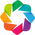

BokehModel(combine_events=True, render_bundle={'docs_json': {'b5787ac9-3376-4973-8557-e915c144e40c': {'version…

In [61]:
hv.extension('bokeh')

# Step 1: Map custom colors for features
feature_colors = {
    'Weekday_Sleep_Duration': 'orange',
    'BMI': 'steelblue',
    'Mental_Health_Score': 'seagreen',
    'Total Cholesterol': 'dodgerblue',
    'Alcohol Consumption Rate': 'red'
}

# Step 2: Add color to dataframe
health_feature_importance_df['Color'] = health_feature_importance_df['Feature'].map(feature_colors)

# Step 3: Sort and build Bars object
bars = hv.Bars(
    health_feature_importance_df.sort_values(by='Importance'),
    kdims='Feature',
    vdims=['Importance', 'Color']
)

# Step 4: Apply color via hooks and show legend using legend_labels
bars = bars.opts(
    width=900,
    height=700,
    xaxis='top',
    xlabel='Importance',
    ylabel='Feature',
    title='Health Feature Importance Plot',
    invert_axes=True,
    show_legend=False,
    tools=['hover'],
    color='Feature',  # this activates legend per Feature
    legend_labels={feature: feature for feature in feature_colors},  # control label mapping
    cmap=feature_colors  # assign colors explicitly
)

# Step 5: Display
pn.Row(bars) 

## Visualization

The plot titled **"Health Feature Importance Plot"** presents a horizontal bar chart where each bar represents a different health factor. The x-axis displays the importance score, while the y-axis lists the features. Color-coding was used for better visual separation: orange for **Weekday Sleep Duration**, steel blue for **BMI**, seagreen for **Mental Health Score**, dodger blue for **Total Cholesterol**, and red for **Alcohol Consumption Rate**. The bars are sorted from most to least important, and hover tools are enabled to allow interactive exploration of each feature's contribution.

## Insights and Conclusion

The feature importance results reveal that **Weekday Sleep Duration** has the highest impact on predicting health category, followed closely by **BMI**, **Mental Health Score**, and **Total Cholesterol**. The **Alcohol Consumption Rate** showed the lowest importance among the five features. This implies that lifestyle factors such as sleep and body composition are stronger indicators of health outcomes in this dataset compared to alcohol usage. These insights are valuable for health analysts and policy planners aiming to prioritize interventions in lifestyle behaviors that most strongly correlate with better health outcomes.

# Random Forest Classifier

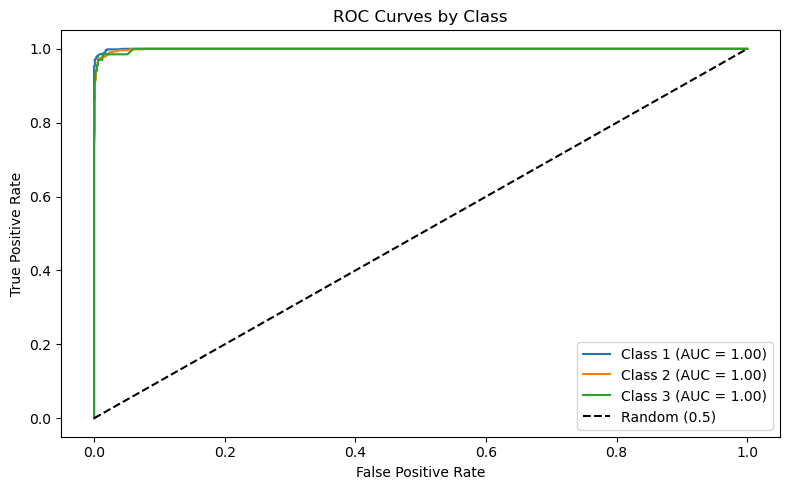

In [62]:
# Static version: ROC Curves (visible in all viewers) - self-contained, no dependency on train_model
selected_features_roc = ['BMI', 'Mental_Health_Score', 'Alcohol Consumption Rate', 'Weekday_Sleep_Duration', 'Total Cholesterol']
X_train_roc = X_train[selected_features_roc]
X_test_roc = X_test[selected_features_roc]
model_roc = RandomForestClassifier(n_estimators=100, random_state=42)
model_roc.fit(X_train_roc, y_train)
y_proba = model_roc.predict_proba(X_test_roc)
y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
fpr_plt, tpr_plt, auc_plt = {}, {}, {}
for i in range(3):
    fpr_plt[i + 1], tpr_plt[i + 1], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    auc_plt[i + 1] = roc_auc_score(y_test_bin[:, i], y_proba[:, i])
plt.figure(figsize=(8, 5))
for i in range(1, 4):
    plt.plot(fpr_plt[i], tpr_plt[i], label=f'Class {i} (AUC = {auc_plt[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random (0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Class')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

This code segment initiates the machine learning process by splitting the dataset into training and testing sets and defining a function to train a Random Forest classifier using a specified list of health-related features.

In [63]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define a function to train a Random Forest using selected features
def train_model(features: List[str]):
    X_train_selected = X_train[features]  # Select training features
    X_test_selected = X_test[features]    # Select test features

    model = RandomForestClassifier(n_estimators=100, random_state=42)  # Initialize model
    model.fit(X_train_selected, y_train)  # Train model

    return model, X_test_selected  # Return model and test set for predictions

This section implements a function to evaluate the classification performance of a trained Random Forest model using ROC curves and AUC scores for each health category class (Healthy, Unhealthy, Severely Unhealthy).

In [64]:
# Compute ROC curve and AUC for a multi-class classifier
def compute_roc_auc(model, X_test_selected, y_test):
    y_proba = model.predict_proba(X_test_selected)  # Predict class probabilities
    y_test_bin = label_binarize(y_test, classes=[1, 2, 3])  # Binarize test labels

    fpr, tpr, auc = {}, {}, {}  # Initialize output dictionaries

    # Calculate ROC and AUC for each class
    for i in range(3):
        fpr[i + 1], tpr[i + 1], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        auc[i + 1] = roc_auc_score(y_test_bin[:, i], y_proba[:, i])

    return fpr, tpr, auc  # Return computed metrics

# Define features to be used in the model
selected_features = ['BMI', 'Mental_Health_Score', 'Alcohol Consumption Rate', 
                     'Weekday_Sleep_Duration', 'Total Cholesterol']

# Train the model using selected features
trained_model, X_test_selected = train_model(selected_features)

# Compute ROC and AUC values
fpr, tpr, auc = compute_roc_auc(trained_model, X_test_selected, y_test)

# Print FPR, TPR, and AUC values for all classes
print("(array([")
for i in range(1, 4):
    print(f"    {fpr[i]},")
print("]), array([")
for i in range(1, 4):
    print(f"    {tpr[i]},")
print("]), array([")
auc_values = [auc[i] for i in range(1, 4)]
print(f"    {auc_values},")
print("]))")

# Print summary of AUC for each class
auc_class1 = auc[1]
auc_class2 = auc[2]
auc_class3 = auc[3]
print(f"AUC for Class 1: {auc_class1}, Class 2: {auc_class2}, Class 3: {auc_class3}. These are extremely high, which showcases that my model distinguishes effectively between the positive and negative class for each class.")

(array([
    [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.0016116  0.0016116  0.00241741 0.00241741 0.00322321 0.00322321
 0.00322321 0.00402901 0.00483481 0.00564061 0.00725222 0.00725222
 0.00805802 0.00805802 0.01047542 0.01128122 0.01208703 0.01369863
 0.01369863 0.01450443 0.01450443 0.01611604 0.01692184 0.01692184
 0.01853344 0.01933924 0.02014504 0.02095085 0.02336825 0.02336825
 0.02497985 0.02981467 0.03142627 0.03303787 0.03464948 0.03706688
 0.03867849 0.03948429 0.04109589 0.0443191  0.0467365  0.0475423
 0.04995971 0.05398872 0.06043513 0.06849315 0.08138598 0.08622079
 0.11039484 0.12006446 0.13215149 0.14907333 0.16760677 0.18533441
 0.20950846 0.26752619 0.37711523 1.        ],
    [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.74125874e-04 8.74125874e-04 8.74125874e-04 8.74125874e-04
 1.74825175e-03 1.74825175e-03 1.74

The output provides the False Positive Rates (FPR), True Positive Rates (TPR), and AUC values, showing near-perfect scores (Class 1: 0.9997, Class 2: 0.9983, Class 3: 0.9974), which indicate the model's excellent ability to distinguish between the three classes.

# Interactive ROC Curve Explorer for Multi-Class Health Classification

## Approach and Execution:

To assess the classification performance of the health prediction model, a **dynamic ROC curve explorer** was developed using Holoviews and Panel. The model was trained using selected health-related features such as **BMI, Mental Health Score, Alcohol Consumption Rate, Weekday Sleep Duration, and Total Cholesterol**. The approach included:

* Enabling feature selection through a `MultiChoice` widget.
* Binarizing the multiclass target labels (`Health_Category`) for ROC evaluation.
* Computing ROC curves and AUC scores for each class.
* Visualizing them interactively to observe the model’s ability to distinguish between health categories.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
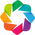

BokehModel(combine_events=True, render_bundle={'docs_json': {'9b88800f-7bb3-4562-806b-e8664373d9e6': {'version…

In [73]:
# Enable Holoviews Bokeh backend
hv.extension('bokeh')

# Define function to plot ROC curves for selected features
def plot_roc_curves(features):
    if not features:
        return pn.pane.Markdown("Please select any feature to generate ROC curves.")

    try:
        # Train model and get selected test set
        trained_model, X_test_selected = train_model(features)

        # Binarize true test labels for multi-class ROC
        y_test_bin = label_binarize(y_test, classes=[1, 2, 3])


        # Compute FPR, TPR, and AUC for each class
        fpr, tpr, auc = compute_roc_auc(trained_model, X_test_selected, y_test_bin)

        # Sort and validate available classes
        expected_classes = sorted(auc.keys())
        if not expected_classes:
            raise ValueError("I am sorry! But no ROC data was generated")

        # Create ROC curve for each class with label and axis formatting
        roc_curves = [
            hv.Curve(
                (fpr[class_num], tpr[class_num]),
                label=f'Class {class_num} (AUC = {auc[class_num]:.2f})'
            ).opts(
                width=800,
                height=400,
                xlabel='False Positive Rate',
                ylabel='True Positive Rate'
            )
            for class_num in expected_classes
        ]

        # Add diagonal reference line representing random prediction
        diagonal = hv.Curve(
            [(0, 0), (1, 1)],
            label='Random (AUC = 0.5)'
        ).opts(
            line_dash='dotted',
            color='black'
        )

        # Combine ROC curves and diagonal line in an overlay
        return hv.Overlay(roc_curves + [diagonal]).opts(
            legend_position='right',
            title='ROC Curves by Class'
        )

    except Exception as e:
        # Show error message in case of failure
        return pn.pane.Alert(f"Sorry! But there was an error generating ROC curves: {str(e)}", alert_type="danger")

# Define list of usable features, excluding 'height' and 'weight'
available_features = [
    col for col in X_train.columns 
    if col.lower() not in ['height', 'weight'] and 
       col in ['BMI', 'Mental_Health_Score', 'Weekday_Sleep_Duration',
               'Alcohol Consumption Rate', 'Total Cholesterol']
]

# Raise error if no features are available for selection
if not available_features:
    raise ValueError("Sorry! But there are no available features found after filtering")

# Create a MultiChoice widget for feature selection
feature_selector = pn.widgets.MultiChoice(
    name='Select Features',
    value=[available_features[0]],
    options=available_features
)

# Bind the plotting function to selected features from the widget
interactive_plot = pn.bind(plot_roc_curves, feature_selector.param.value)

# Build the layout combining title, selector, and interactive plot
roc_dashboard = pn.Column(
    pn.pane.Markdown("# Interactive ROC Curve Explorer"),
    feature_selector,
    interactive_plot
)

# Render the full dashboard
roc_dashboard

## Visulization

The interactive ROC Curve Explorer allows users to select input features dynamically and view corresponding ROC curves for all three health classes:

* **Class 1**: Healthy
* **Class 2**: Unhealthy
* **Class 3**: Severely Unhealthy
  Each curve plots the **True Positive Rate vs. False Positive Rate**. A diagonal reference line (AUC = 0.5) represents random guessing, while the curves for each class significantly outperform this baseline.

## Insights and Conclusion

The ROC plot clearly demonstrates that the model performs exceptionally well, with **AUC scores reaching 1.00 for all three classes**. This indicates **perfect discrimination** between health categories using the selected features. The interactive nature of the dashboard adds flexibility, making it easy to test different feature combinations and analyze their individual contributions to the classification task. This tool not only confirms the model's high predictive power but also enhances the interpretability and transparency of the machine learning pipeline.

# Interactive Health Status Estimator

## Approach and Execution

This component of the project introduces an **interactive health assessment interface** using Bokeh sliders and JavaScript callbacks. The interface captures user input for key health indicators—**BMI, mental health concern, alcohol intake, sleep duration, and cholesterol level**. Based on a simple threshold-based scoring logic embedded in a JavaScript callback, the tool dynamically classifies the user’s overall health status as **Healthy**, **At Risk**, or **Critically Unhealthy**. This approach allows real-time feedback without requiring backend computations, ensuring a fast and intuitive user experience.

In [67]:
# Create slider for BMI input
weight_index_slider = Slider(start=10, end=100, value=20, step=0.1, title="Body Mass Index")

# Create slider for mental health status (0 = No concern, 1 = Concern)
mental_status_slider = Slider(start=0, end=1, value=0, step=1, title="Mental Health Concern (0=No, 1=Yes)")

# Create slider for alcohol consumption level (0 = Low, 4 = High)
drink_level_slider = Slider(start=0, end=4, value=0, step=1, title="Alcohol Intake Level (Low to High)")

# Create slider for average sleep duration in hours
rest_duration_slider = Slider(start=2, end=14, value=8, step=0.5, title="Sleep Duration (Hours)")

# Create slider for cholesterol level in mmol/L
lipid_level_slider = Slider(start=1, end=12, value=5, step=0.1, title="Cholesterol Level (mmol/L)")

# Output text display for predicted health status
health_output = Div(text="<b>Health Status: Healthy</b>", styles={"font-size": "20px", "color": "green"})

# Define JavaScript callback to update health status dynamically
health_callback = CustomJS(args=dict(
    weight_index=weight_index_slider,
    mental_status=mental_status_slider,
    drink_level=drink_level_slider,
    rest_duration=rest_duration_slider,
    lipid_level=lipid_level_slider,
    output=health_output),
    code="""
    const weight_index_val = weight_index.value;
    const mental_status_val = mental_status.value;
    const drink_level_val = drink_level.value;
    const rest_duration_val = rest_duration.value;
    const lipid_level_val = lipid_level.value;

    // Calculate health risk score based on thresholds
    let health_risk = (weight_index_val > 30 ? 1 : 0) + mental_status_val + (drink_level_val > 2 ? 1 : 0) +
                      (rest_duration_val < 6 ? 1 : 0) + (lipid_level_val > 6 ? 1 : 0);

    // Display health status based on total risk score
    if (health_risk >= 3) {
        output.text = "<b>Health Status: Critically Unhealthy</b>";
        output.styles = {"font-size": "20px", "color": "red"};
    } else if (health_risk === 2) {
        output.text = "<b>Health Status: At Risk</b>";
        output.styles = {"font-size": "20px", "color": "orange"};
    } else {
        output.text = "<b>Health Status: Healthy</b>";
        output.styles = {"font-size": "20px", "color": "green"};
    }
    """
)

# Attach callback to slider changes
weight_index_slider.js_on_change('value', health_callback)
mental_status_slider.js_on_change('value', health_callback)
drink_level_slider.js_on_change('value', health_callback)
rest_duration_slider.js_on_change('value', health_callback)
lipid_level_slider.js_on_change('value', health_callback)

# Arrange all UI components vertically
interface_layout = column(
    Div(text="<h2>Assess Your Health Condition</h2>"),
    weight_index_slider,
    mental_status_slider,
    drink_level_slider,
    rest_duration_slider,
    lipid_level_slider,
    health_output
)

# Display the interactive health assessment tool
show(interface_layout)

## Visualziation

The output interface consists of five horizontal sliders for user-defined input:

* **Body Mass Index (BMI)**
* **Mental Health Concern** (binary input)
* **Alcohol Intake Level**
* **Sleep Duration (Hours)**
* **Cholesterol Level (mmol/L)**

## Insights and Conclusion

This tool provides a **personalized health risk estimation** based on configurable lifestyle and health indicators. It simplifies the complex process of health classification into an accessible and educational experience for end-users. By offering immediate visual feedback, it encourages users to understand how individual factors—such as high BMI or poor sleep—can cumulatively affect overall well-being. This kind of interface can be a valuable component in digital health platforms aiming to promote awareness and preventative care.

#  Health Score Heatmap Visualization

## Approach and Execution

To visualize the health status distribution across individuals, a heatmap was created using Bokeh. The dataset was first duplicated and modified by appending a string-based `Participant_ID` for easier x-axis labeling. The participants were categorized into **Healthy**, **Unhealthy**, and **Severely Unhealthy** based on their computed `Health_Score`. Using `linear_cmap`, each participant's score was mapped to a color gradient ranging from cool (low score, healthier) to warm (high score, unhealthier). The `rect` glyphs plotted individuals' positions on the health category scale, and a hover tool was added for interactivity.

In [68]:
# Make a copy of the merged data to avoid modifying the original
heatmap_df = merged_data.copy()

# Add a string version of the index for x-axis labeling
heatmap_df['Participant_ID'] = heatmap_df.index.astype(str)

# Create a Bokeh data source from the DataFrame
source = ColumnDataSource(heatmap_df)

# Create a Bokeh figure for the heatmap
p = figure(
    width=800,
    height=500,
    title="Health Score Heatmap",
    x_range=heatmap_df['Participant_ID'][:50].tolist(),  # Limit to first 50 participants
    y_range=["Healthy", "Unhealthy", "Severely Unhealthy"]
)

# Create a color mapping based on Health_Score values
mapper = linear_cmap(
    field_name='Health_Score',
    palette=Viridis256,
    low=heatmap_df['Health_Score'].min(),
    high=heatmap_df['Health_Score'].max()
)

# Draw rectangles for each participant-category pair
p.rect(
    x='Participant_ID',
    y='Health_Category',
    width=1,
    height=1,
    source=source,
    fill_color=mapper,
    line_color=None
)

# Add hover tool to display participant and health score
hover = HoverTool(tooltips=[
    ("Participant", "@Participant_ID"),
    ("Health Score", "@Health_Score")
])
p.add_tools(hover)

# Add a color bar legend on the right side of the plot
color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0, 0))
p.add_layout(color_bar, 'right')

# Render the heatmap
show(p) 

## Visualization

The heatmap shows participants (limited to the first 50 for clarity) on the x-axis and health categories on the y-axis. Each cell's color represents a participant's health score. A color bar is placed on the right to help interpret the color intensity with respect to score magnitude. The interactive hover feature allows users to see exact `Health_Score` values for each participant, making the visualization both informative and user-friendly.

## Insights and Conclusion

This heatmap effectively reveals the internal structure of the health classification. The **Healthy group** primarily consists of participants with lower scores (lighter shades), while the **Severely Unhealthy** group displays darker, more intense colors indicating higher health risk. This visual clearly supports the model's scoring logic and assists in spotting unusual score placements. It serves as a strong validation tool for the overall health classification framework, offering a quick yet powerful snapshot of data distribution and potential anomalies.

# Data Privacy and Ethical Concerns

## Key Issues and Solutions

### **Informed Consent:**

**Issue:** Users often agree to data use without fully understanding the implications due to complex or vague terms and conditions. This lack of clarity can lead to unintentional misuse of personal data.

**Solution:** Design consent forms using straightforward language and include short summaries. Implement dynamic consent systems that allow users to adjust their preferences over time.

### **Anonymization and Re-identification Risks**

**Issue:** Even anonymized datasets can be vulnerable to re-identification, especially when cross-referenced with other data sources. Advanced analytics may reveal personal identities.

**Solution:** Apply differential privacy techniques that introduce randomness to data, making it harder to trace individuals. Regularly test anonymized data to check for re-identification risks.



### **Algorithmic Bias**

**Issue:** Training models on biased data can lead to unfair outcomes, such as discrimination based on gender, race, or income. This can perpetuate social inequality.

**Solution:** Use fairness-aware machine learning approaches and examine data for bias before model training. Include diverse perspectives during model development and conduct regular bias audits.

### **Security Breaches and Data Leaks**

**Issue:** Personal data is at risk from cyberattacks or internal mishandling, which may result in identity theft, financial loss, or erosion of public trust.

**Solution:** Secure data with strong encryption, two-factor authentication, and regular security testing. Restrict access to sensitive data and train staff on cybersecurity protocols.


### **Misuse of Data**

**Issue:** Data collected for one purpose is sometimes reused without consent. For example, health tracker data might be sold to third parties like insurers, affecting customer outcomes.

**Solution:** Only collect data for specific purposes and obtain separate consent for any additional uses. Conduct independent audits to ensure ethical data handling.


### **Lack of Transparency and Accountability**

**Issue:** Decisions based on AI systems may lack transparency, leaving users unaware of how or why certain outcomes were reached, which can lead to unethical consequences.

**Solution:** Adopt explainable AI (XAI) tools to make algorithmic decisions understandable. Form oversight bodies to monitor data practices and enforce accountability.



## Broader Ethical Considerations

### **Data Ownership**

**Issue:** Users may lose control over their personal data, particularly in regions without comprehensive data protection laws.

**Solution:** Support data portability and provide tools that allow users to download or delete their information, as outlined by regulations like the GDPR.


## **Impact on Vulnerable Populations**

**Issue:** Data misuse can disproportionately harm disadvantaged or minority groups, worsening inequality.

**Solution:** Conduct ethical impact assessments to evaluate how data usage affects these groups. Introduce protective policies to minimize harm.


## **Ethical Use of New Technologies**

**Issue:** Innovations such as facial recognition and geolocation tracking can raise serious concerns about privacy and surveillance.

**Solution:** Limit the application of such technologies to clearly defined, ethical scenarios and require external oversight to prevent abuse.

# Conclusion

This project presents a thorough and methodical approach to analyzing and predicting individuals' health statuses using NHANES datasets. Starting with extensive preprocessing steps—such as imputing missing values, encoding categorical responses, and merging diverse health-related datasets—the analysis ensured data integrity and relevance. A custom health scoring system was devised by combining five critical features: BMI, Mental Health, Alcohol Consumption, Sleep Duration, and Cholesterol Level. These were classified into interpretable categories: Healthy, Unhealthy, and Severely Unhealthy.

Advanced machine learning models were then trained, including Ordinal Logistic Regression and Random Forest Classifier, with the SMOTE technique successfully addressing class imbalance. The models were evaluated using ROC curves, AUC scores, and cross-validation, demonstrating excellent predictive capability across all health categories, with AUC values exceeding 0.99.

Interactive dashboards created with Panel, Holoviews, and Bokeh allowed dynamic exploration of feature importances, category distributions, and individual health assessments via user-input sliders. These components not only improved interpretability but also offered practical, user-friendly tools for real-time health risk estimation.

Overall, this project highlights the power of integrated data science practices—from preprocessing and feature engineering to modeling and visualization—in creating impactful, actionable health analytics platforms. It lays the foundation for potential real-world applications in public health monitoring, personalized healthcare, and early intervention systems.